# Adding regions to the dataset

Because the USA is a very large country, it is a good idea to split the country in 4 regions. This is because weather conditions are very different between north and south. The original graphs didn't show much correlation between winter and summer delays. By adding the regions I want to see if northern airports are more prone to delays during winter. I found another dataset that includes all longitudes and latitudes of the origin airports. I split the country into 4 regions. I will connect this dataset with the original dataset to create a new column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df = pd.read_csv("C:/Users/noahk/Downloads/schoon.csv")  
airports = pd.read_csv("C:/Users/noahk/Downloads/airports.csv")
airports = airports[['iata_code', 'name', 'latitude_deg', 'longitude_deg']]


df = df.merge(airports, left_on='ORIGIN', right_on='iata_code', how='left')
df = df.rename(columns={'latitude_deg': 'Origin_Latitude', 'longitude_deg': 'Origin_Longitude'})


def categorize_airport(lat, lon):
    if lat is None or lon is None:
        return 'Unknown'
    if lat > 37:
        if lon < -97:
            return 'North-West'
        else:
            return 'North-East'
    else:
        if lon < -97:
            return 'South-West'
        else:
            return 'South-East'


df['Airport_Region'] = df.apply(lambda row: categorize_airport(row['Origin_Latitude'], row['Origin_Longitude']), axis=1)


sample_df = df.sample(n=10, random_state=1)  
print(sample_df)




            FL_DATE                 AIRLINE                 AIRLINE_DOT  \
2261797  2020-07-18  Southwest Airlines Co.  Southwest Airlines Co.: WN   
834754   2019-09-07  American Airlines Inc.  American Airlines Inc.: AA   
2194547  2023-03-12  American Airlines Inc.  American Airlines Inc.: AA   
2144867  2021-06-08  Southwest Airlines Co.  Southwest Airlines Co.: WN   
1909622  2019-11-27   United Air Lines Inc.   United Air Lines Inc.: UA   
2067197  2020-04-15        Spirit Air Lines        Spirit Air Lines: NK   
441702   2019-04-20   SkyWest Airlines Inc.   SkyWest Airlines Inc.: OO   
1808952  2019-01-03  American Airlines Inc.  American Airlines Inc.: AA   
2467802  2022-06-01  American Airlines Inc.  American Airlines Inc.: AA   
2882147  2022-11-12       Endeavor Air Inc.       Endeavor Air Inc.: 9E   

        AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN       ORIGIN_CITY DEST  \
2261797           WN     19393        576    DEN        Denver, CO  PHX   
834754            AA    

Now I'm going to look if certain airports were not in the other dataset.

In [29]:
print(df.isnull().sum())

FL_DATE                          0
AIRLINE                          0
AIRLINE_DOT                      0
AIRLINE_CODE                     0
DOT_CODE                         0
FL_NUMBER                        0
ORIGIN                           0
ORIGIN_CITY                      0
DEST                             0
DEST_CITY                        0
CRS_DEP_TIME                     0
DEP_TIME                         0
DEP_DELAY                        0
TAXI_OUT                         0
WHEELS_OFF                       0
WHEELS_ON                        0
TAXI_IN                          0
CRS_ARR_TIME                     0
ARR_TIME                         0
ARR_DELAY                        0
CANCELLED                        0
CANCELLATION_CODE          2913802
DIVERTED                         0
CRS_ELAPSED_TIME                 0
ELAPSED_TIME                     0
AIR_TIME                         0
DISTANCE                         0
DELAY_DUE_CARRIER                0
DELAY_DUE_WEATHER   

In [14]:
df = df.dropna(subset=['iata_code'])
df.isnull().sum()
df.to_csv('met_regions.csv', index=False) #this is the dataset for my model

I got rid of those airports because they were very small ones with almost no daily flights. The target audience will almost never have anything to do with these airports.

# Delay timeline Northern regions

To show if different seasons affect arrival delays (above 60 minutes), a timeline could be made. Because the dataset covers multiple years, you can see if there are reoccuring patterns. The barplots shows the average delay percentages every month for every region.

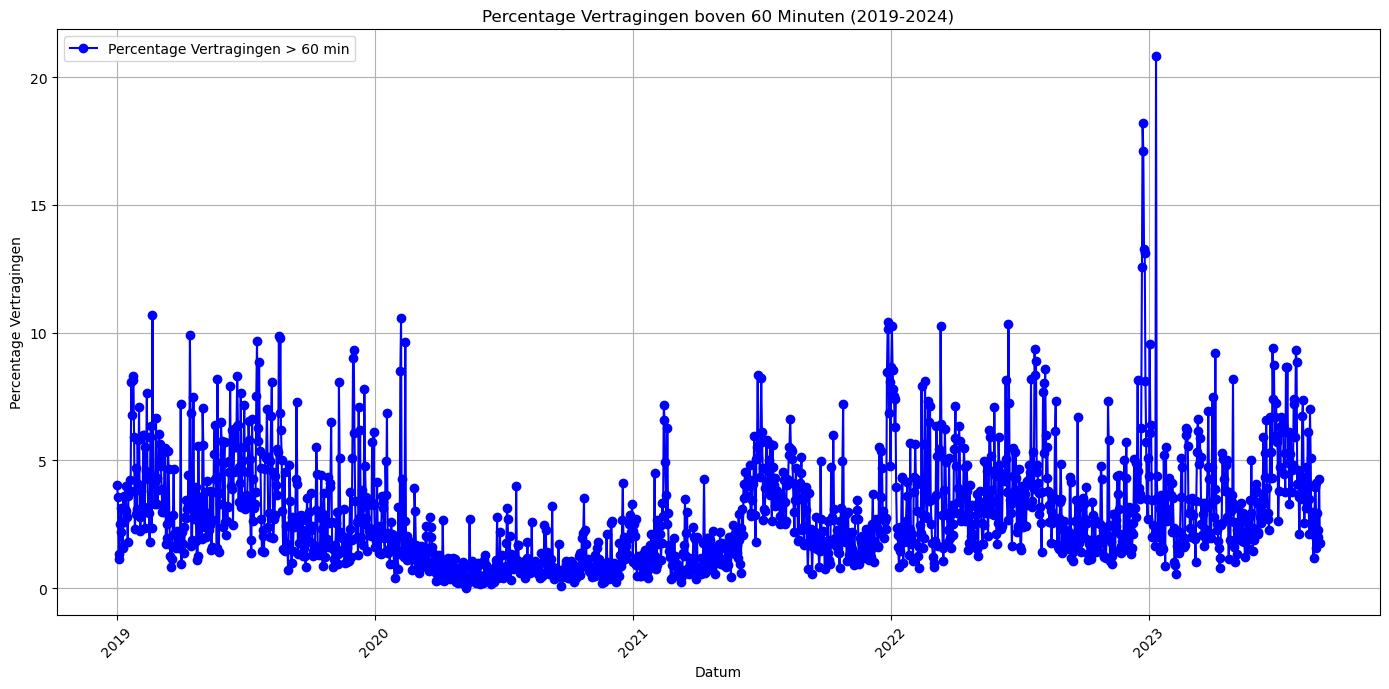

In [2]:

regions = ['North-West', 'North-East']
df_filtered = df[df['Airport_Region'].isin(regions)]


df_filtered = df_filtered[df_filtered['ARR_DELAY'] > 60]

df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])  
df_filtered['FL_DATE'] = pd.to_datetime(df_filtered['FL_DATE'])  

total_flights_per_day = df.groupby('FL_DATE').size().reset_index(name='Total_Flights')

delays_per_day = df_filtered.groupby('FL_DATE').size().reset_index(name='Delayed_Flights')

merged_data = total_flights_per_day.merge(delays_per_day, on='FL_DATE', how='left').fillna(0)

merged_data['Percentage_Delayed'] = (merged_data['Delayed_Flights'] / merged_data['Total_Flights']) * 100


plt.figure(figsize=(14, 7))
plt.plot(merged_data['FL_DATE'], merged_data['Percentage_Delayed'], label='Percentage Vertragingen > 60 min', color='blue', marker='o')


plt.title('Percentage Vertragingen boven 60 Minuten (2019-2024)')
plt.xlabel('Datum')
plt.ylabel('Percentage Vertragingen')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Delay timeline in Southern regions

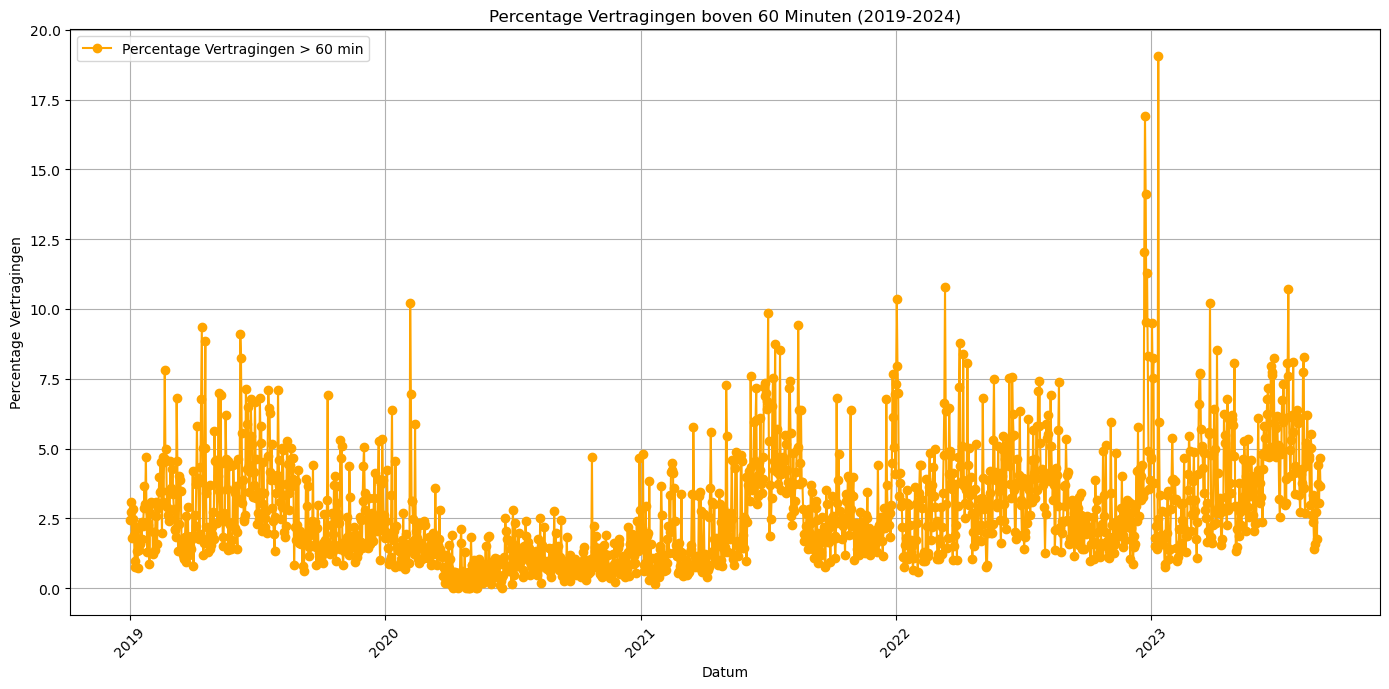

In [3]:
regions = ['South-East', 'South-West']
df_filtered = df[df['Airport_Region'].isin(regions)]


df_filtered = df_filtered[df_filtered['ARR_DELAY'] > 60]


df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])  
df_filtered['FL_DATE'] = pd.to_datetime(df_filtered['FL_DATE'])  


total_flights_per_day = df.groupby('FL_DATE').size().reset_index(name='Total_Flights')


delays_per_day = df_filtered.groupby('FL_DATE').size().reset_index(name='Delayed_Flights')


merged_data = total_flights_per_day.merge(delays_per_day, on='FL_DATE', how='left').fillna(0)


merged_data['Percentage_Delayed'] = (merged_data['Delayed_Flights'] / merged_data['Total_Flights']) * 100


plt.figure(figsize=(14, 7))
plt.plot(merged_data['FL_DATE'], merged_data['Percentage_Delayed'], label='Percentage Vertragingen > 60 min', color='orange', marker='o')


plt.title('Percentage Vertragingen boven 60 Minuten (2019-2024)')
plt.xlabel('Datum')
plt.ylabel('Percentage Vertragingen')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

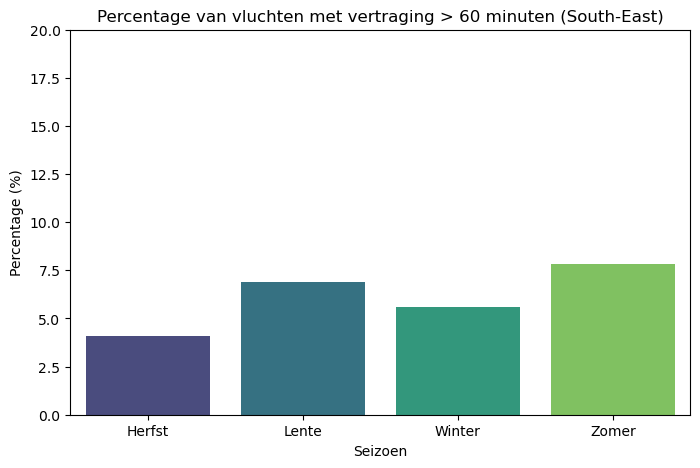

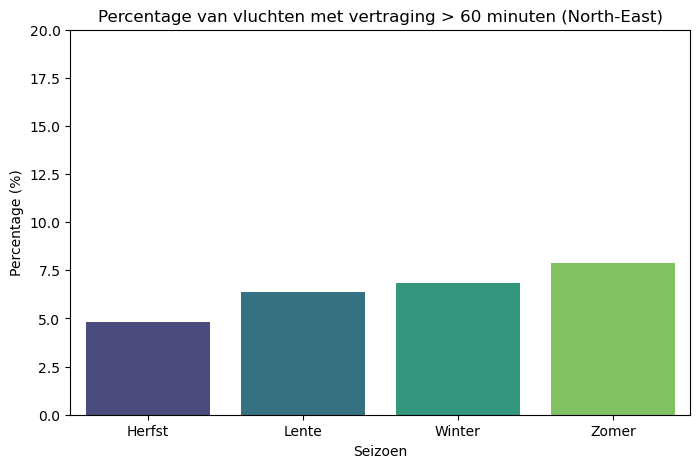

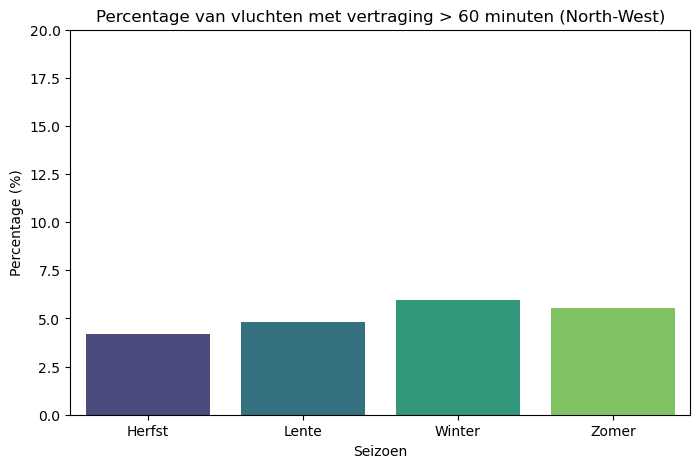

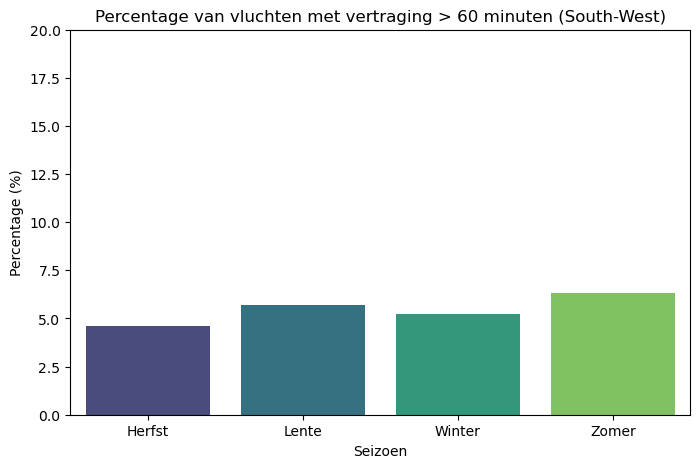

In [7]:


df['Delayed'] = df['ARR_DELAY'] > 60
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')
def bepaal_seizoen(datum):
    jaar = datum.year
    lente_start = pd.Timestamp(f'{jaar}-03-21')
    zomer_start = pd.Timestamp(f'{jaar}-06-21')
    herfst_start = pd.Timestamp(f'{jaar}-09-23')
    winter_start = pd.Timestamp(f'{jaar}-12-21')
    if lente_start <= datum < zomer_start:
        return 'Lente'
    elif zomer_start <= datum < herfst_start:
        return 'Zomer'
    elif herfst_start <= datum < winter_start:
        return 'Herfst'
    else:
        return 'Winter'

df['Seizoen'] = df['FL_DATE'].apply(bepaal_seizoen)

percentage_df = (
    df.groupby(['Airport_Region', 'Seizoen'])['Delayed']
    .mean()
    .reset_index()
    .rename(columns={'Delayed': 'Percentage'})
)
percentage_df['Percentage'] *= 100  


regions = df['Airport_Region'].unique()

for region in regions:
    region_data = percentage_df[percentage_df['Airport_Region'] == region]
    plt.figure(figsize=(8, 5))
    sns.barplot(data=region_data, x='Seizoen', y='Percentage', palette='viridis')
    plt.title(f'Percentage van vluchten met vertraging > 60 minuten ({region})')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 20)
    plt.xlabel('Seizoen')
    plt.show()


When comparing northern and southern regions, it can be seen that there are not many differences in patterns. Both categories have relatively higher delays during the Holidays and during peak season. But when looking at the percentages, you can conclude that the winter season is the second highest delay season for North-East and highest for North-West. For the Southern airports, winter is third. This can suggest that there is some correlation going on between region and arrival delay.

# Delays John F. Kennedy Airport (New York)

A timeline for a specific airport can show if the trends found in the earlier graphs, also apply for individual airports. I also made bar plots with the average delay percentage.

C:\Users\noahk\AppData\Local\Temp\ipykernel_19828\1806453425.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jfk['FL_DATE'] = pd.to_datetime(df_jfk['FL_DATE'])
C:\Users\noahk\AppData\Local\Temp\ipykernel_19828\1806453425.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jfk_filtered['FL_DATE'] = pd.to_datetime(df_jfk_filtered['FL_DATE'])


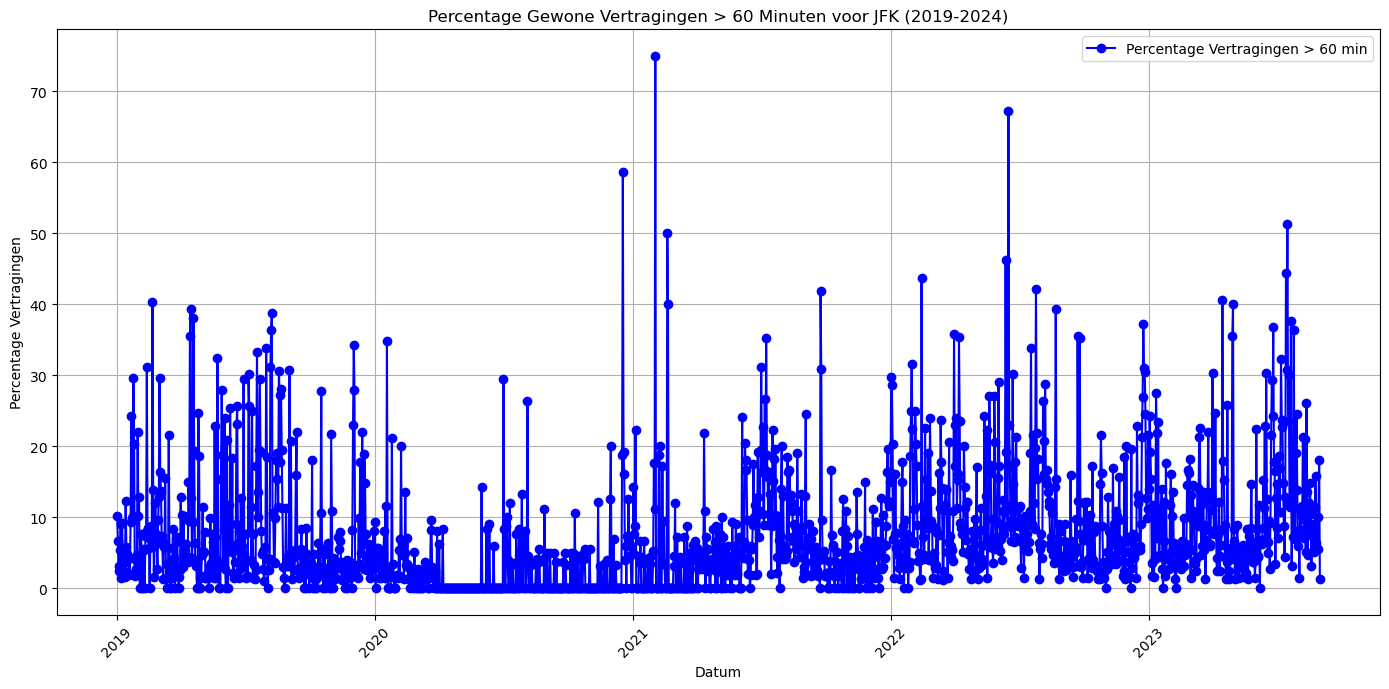

In [4]:
df_jfk = df[(df['ORIGIN'] == 'JFK') | (df['DEST'] == 'JFK')]


df_jfk_filtered = df_jfk[df_jfk['ARR_DELAY'] > 60]


df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])  
df_jfk['FL_DATE'] = pd.to_datetime(df_jfk['FL_DATE'])  
df_jfk_filtered['FL_DATE'] = pd.to_datetime(df_jfk_filtered['FL_DATE'])  


total_flights_per_day = df_jfk.groupby('FL_DATE').size().reset_index(name='Total_Flights')


delays_per_day = df_jfk_filtered.groupby('FL_DATE').size().reset_index(name='Delayed_Flights')


merged_data_jfk = total_flights_per_day.merge(delays_per_day, on='FL_DATE', how='left').fillna(0)


merged_data_jfk['Percentage_Delayed'] = (merged_data_jfk['Delayed_Flights'] / merged_data_jfk['Total_Flights']) * 100


plt.figure(figsize=(14, 7))
plt.plot(merged_data_jfk['FL_DATE'], merged_data_jfk['Percentage_Delayed'], label='Percentage Vertragingen > 60 min', color='blue', marker='o')

plt.title('Percentage Gewone Vertragingen > 60 Minuten voor JFK (2019-2024)')
plt.xlabel('Datum')
plt.ylabel('Percentage Vertragingen')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Delays at LAX (Los Angeles)

C:\Users\noahk\AppData\Local\Temp\ipykernel_19828\3637761415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jfk['FL_DATE'] = pd.to_datetime(df_jfk['FL_DATE'])
C:\Users\noahk\AppData\Local\Temp\ipykernel_19828\3637761415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jfk_filtered['FL_DATE'] = pd.to_datetime(df_jfk_filtered['FL_DATE'])


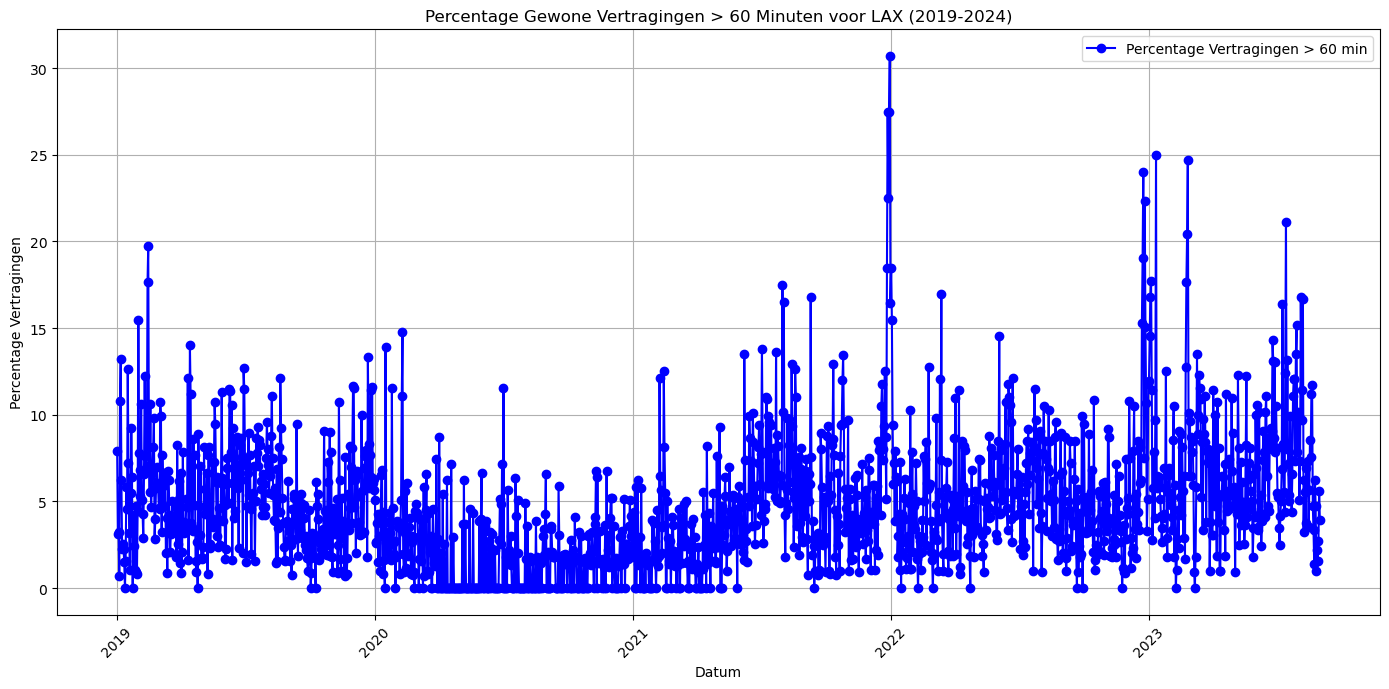

In [5]:
df_jfk = df[(df['ORIGIN'] == 'LAX') | (df['DEST'] == 'LAX')]


df_jfk_filtered = df_jfk[df_jfk['ARR_DELAY'] > 60]


df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])  
df_jfk['FL_DATE'] = pd.to_datetime(df_jfk['FL_DATE'])  
df_jfk_filtered['FL_DATE'] = pd.to_datetime(df_jfk_filtered['FL_DATE'])  


total_flights_per_day = df_jfk.groupby('FL_DATE').size().reset_index(name='Total_Flights')


delays_per_day = df_jfk_filtered.groupby('FL_DATE').size().reset_index(name='Delayed_Flights')


merged_data_jfk = total_flights_per_day.merge(delays_per_day, on='FL_DATE', how='left').fillna(0)


merged_data_jfk['Percentage_Delayed'] = (merged_data_jfk['Delayed_Flights'] / merged_data_jfk['Total_Flights']) * 100


plt.figure(figsize=(14, 7))
plt.plot(merged_data_jfk['FL_DATE'], merged_data_jfk['Percentage_Delayed'], label='Percentage Vertragingen > 60 min', color='blue', marker='o')


plt.title('Percentage Gewone Vertragingen > 60 Minuten voor LAX (2019-2024)')
plt.xlabel('Datum')
plt.ylabel('Percentage Vertragingen')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# JFK percentage delays above 60 minutes per month

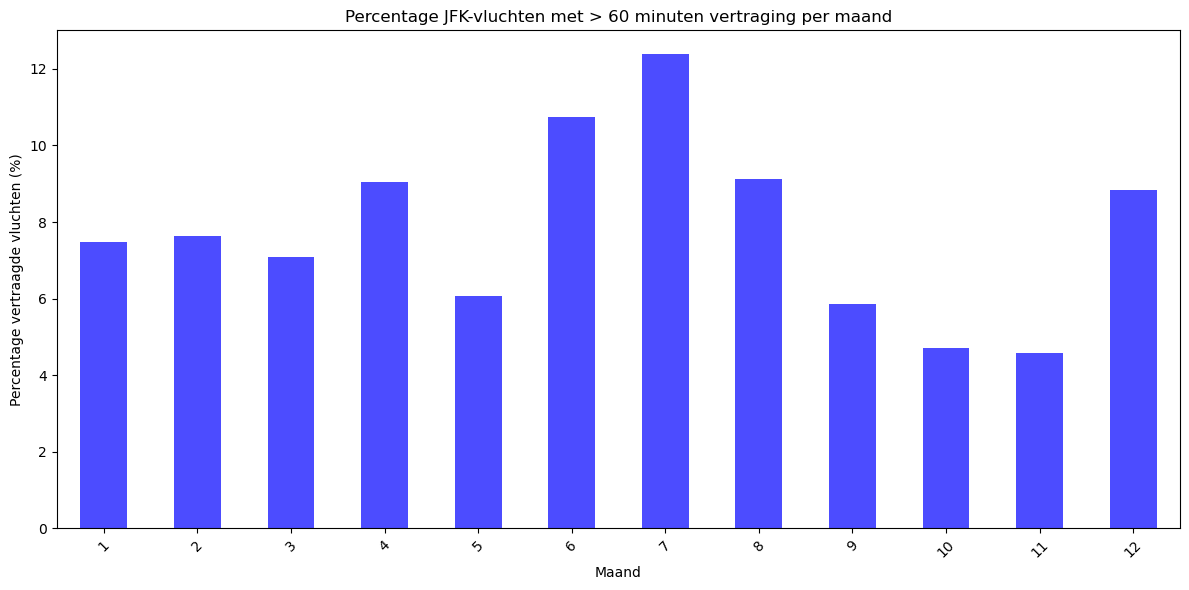

In [3]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])


df_jfk = df[df['ORIGIN'] == 'JFK']




delayed_counts = df_jfk[df_jfk['ARR_DELAY'] > 60].groupby('Month').size()
total_counts = df_jfk.groupby('Month').size()
percentage_delayed = (delayed_counts / total_counts) * 100


plt.figure(figsize=(12, 6))
percentage_delayed.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Percentage JFK-vluchten met > 60 minuten vertraging per maand')
plt.xlabel('Maand')
plt.ylabel('Percentage vertraagde vluchten (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

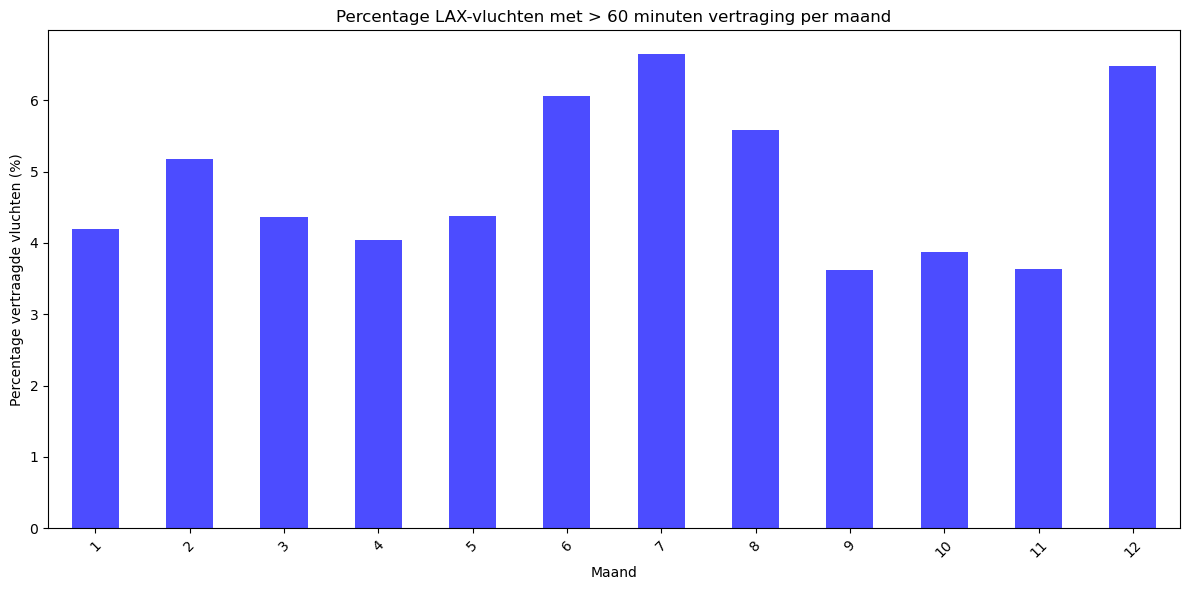

In [6]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])


df_jfk = df[df['ORIGIN'] == 'LAX']




delayed_counts = df_jfk[df_jfk['ARR_DELAY'] > 60].groupby('Month').size()
total_counts = df_jfk.groupby('Month').size()
percentage_delayed = (delayed_counts / total_counts) * 100


plt.figure(figsize=(12, 6))
percentage_delayed.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Percentage LAX-vluchten met > 60 minuten vertraging per maand')
plt.xlabel('Maand')
plt.ylabel('Percentage vertraagde vluchten (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The conclusions that can be made from these graph are that those airports also have the same trends. More delays during vacation period and the Holidays. But you can also see that LAX has more variation of delay percentages everyday while JFK are more consistent. Overall, JFK has a higher delay percentage as LAX, which indicates that origin airports are of importance to the target variable arrival delay

# Conclusions EDA

There are several conclusions that can be made based on this EDA: <br>
- The day of the week doesn't have significant correlations with arrival delay <br>
- The time of the year does have correlations with arrival delay <br>
- The airlines do have significant correlations with arrival delay <br>
- Most delays occur during peak season, holidays or extreme weather <br>
- Distance doesn't have significant correlations with arrival delay <br>
- Regions do have correlations with arrival delay <br>
- Airports also have impact on arrival delay <br>

### What to do next <br>
I discussed the EDA with Hans. We came to the conclusion that the data preparation was done sufficiently and the EDA had given me proper insights. I am now moving on to the final data preparation, because I have categorical variables which the model cannot use. I have to encode those and then I can move on to the next step within the data science methodology, modelling.
